# Thompson Sampling

## 1. 개요
- **확률적 탐색(Exploration)과 활용(Exploitation)** 을 균형 있게 수행하는 **Multi-Armed Bandit 문제**의 해결 기법 중 하나
- 베이지안 확률 모델을 기반으로 각 선택지(팔, Arm)의 보상 분포를 샘플링하여 최적의 행동을 선택하는 방식
- **초반에는 exploration, 데이터가 쌓이면 exploitation!**


## 2. Multi-Armed Bandit 문제란?
- 여러 개의 슬롯 머신(Arm)이 있고, 각 머신은 서로 다른 확률로 보상을 준다고 가정
- 목표: 여러 번 시도하여 **가장 높은 기대 보상을 주는 슬롯 머신을 찾는 것**
- 탐험(Exploration)과 활용(Exploitation)의 균형이 필요


## 3. 톰슨 샘플링 알고리즘
- 각 행동(Arm)의 보상 확률을 베이지안 모델로 추정하여 샘플링한 뒤, 가장 높은 보상을 예측하는 행동을 선택

### **1) 베타 분포(Beta Distribution) 활용**
- 이진 보상(성공/실패) 문제에서는 **베타 분포**(Beta Distribution)를 사용
- 각 슬롯 머신(Arm)의 승률 $\theta$ 를 베타 분포로 모델링

  \[
  P($\theta$ | S, F) = Beta(S + 1, F + 1)
  \]

  - \( S \) : 성공 횟수
  - \( F \) : 실패 횟수
  - 초기값: \( Beta(1,1) \) → **균일 분포**

### **2) 샘플링 및 행동 선택**
1. 각 Arm에 대해 베타 분포에서 $\theta$ 값을 샘플링
2. 샘플링된 값이 가장 큰 Arm을 선택하여 실행
3. 실행 결과(성공/실패)에 따라 해당 Arm의 베타 분포를 업데이트


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

class ThompsonSampling:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.alpha = np.ones(n_arms)  # 성공 횟수
        self.beta = np.ones(n_arms)   # 실패 횟수
        
    def select_arm(self):  # 각기 다른 beta 분포를 따르는 arm들에서 샘플링을 하고, 가장 큰 값의 arm을 select. 낮은 확률로 exploration!
        samples = [np.random.beta(self.alpha[i], self.beta[i]) for i in range(self.n_arms)]
        return np.argmax(samples)  # max 값의 인덱스 (=arm)
    
    def update(self, chosen_arm, reward):  # 각 arm에 대한 베타분포 피드백 데이터 기반 반영 (점점 뾰족해짐)
        if reward == 1:
            self.alpha[chosen_arm] += 1
        else:
            self.beta[chosen_arm] += 1


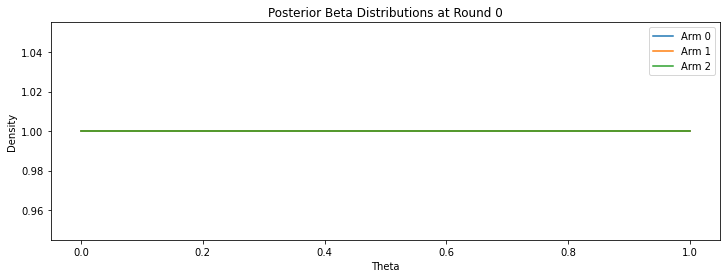

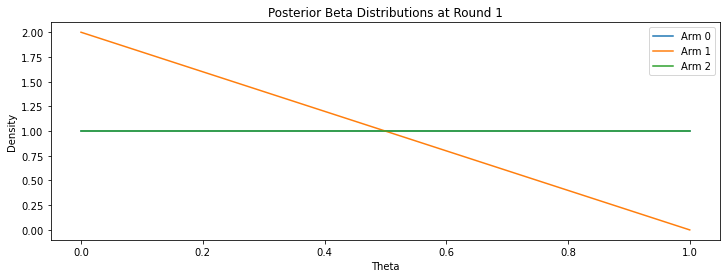

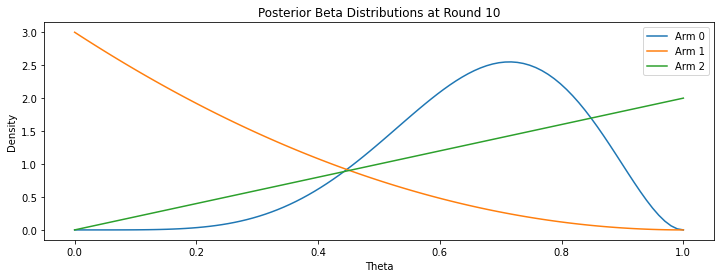

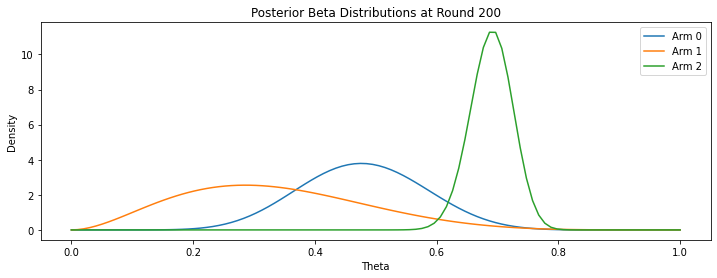

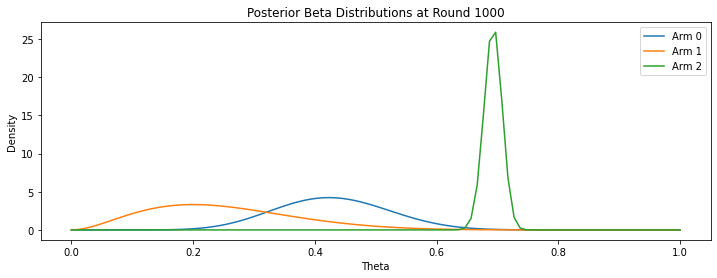

Arm 0: Pulled 26.0 times, Estimated Probability 0.42
Arm 1: Pulled 10.0 times, Estimated Probability 0.20
Arm 2: Pulled 964.0 times, Estimated Probability 0.69


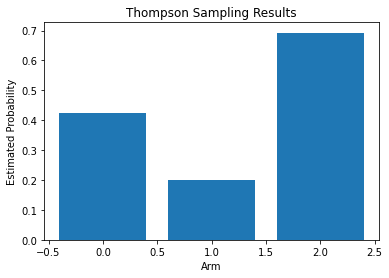

In [8]:

# 시뮬레이션 설정
n_arms = 3
true_probs = [0.3, 0.5, 0.7]  # 실제 각 팔의 보상 확률 (unknown)
n_rounds = 1000
checkpoint_rounds = [0, 1, 10, 200, 1000]  # 초기, 중간, 최종 시점 시각화

# 학습 과정 저장용
ts = ThompsonSampling(n_arms)
rewards = np.zeros(n_arms)
counts = np.zeros(n_arms)

# 시각화 함수
def plot_beta_distributions(ts, round_num):
    plt.figure(figsize=(12, 4))
    x = np.linspace(0, 1, 100)
    for i in range(n_arms):
        plt.plot(x, beta.pdf(x, ts.alpha[i], ts.beta[i]), label=f"Arm {i}")
    plt.xlabel("Theta")
    plt.ylabel("Density")
    plt.title(f"Posterior Beta Distributions at Round {round_num}")
    plt.legend()
    plt.show()

# 초기 상태 시각화
plot_beta_distributions(ts, 0)

for round_num in range(1, n_rounds + 1):
    chosen_arm = ts.select_arm()  # arm 선택
    reward = np.random.rand() < true_probs[chosen_arm]  # 실제 확률 (unknown) 기반 reward 
    ts.update(chosen_arm, reward)  # 선택된 arm의 beta 분포 업데이트
    rewards[chosen_arm] += reward
    counts[chosen_arm] += 1
    
    if round_num in checkpoint_rounds:
        plot_beta_distributions(ts, round_num)

# 결과 출력
for i in range(n_arms):
    print(f"Arm {i}: Pulled {counts[i]} times, Estimated Probability {rewards[i] / counts[i]:.2f}")

# 확률 막대 그래프
plt.figure(figsize=(6, 4))
plt.bar(range(n_arms), rewards / counts)
plt.xlabel("Arm")
plt.ylabel("Estimated Probability")
plt.title("Thompson Sampling Results")
plt.show()